<a href="https://colab.research.google.com/github/2203A51205jashwanth/2203A51205_DAA/blob/main/Child_mind_institute.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install colorama

In [ ]:
import numpy as np
import pandas as pd
import polars as pl
import os, time, copy
import gc, json, random
from pathlib import Path

import itertools
from scipy import stats
from scipy.optimize import minimize
from scipy.spatial.distance import cdist

import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from colorama import Style, Fore
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
!ls ../input/*
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline


ls: cannot access '../input/*': No such file or directory


In [ ]:
SEED = 42

# Load the data
train_data = pd.read_csv('/content/train.csv')
test_data = pd.read_csv('/content/test.csv')

### **Data Cleaning and Preprocessing**

# Handling missing values in training data
threshold = 0.5 * len(train_data)
columns_with_data = train_data.columns[train_data.isnull().sum() < threshold]
train_data = train_data[columns_with_data]
train_data.fillna(0, inplace=True)
# Define the target column
target_column = 'sii'

# Drop rows where the target is missing
train_data_cleaned = train_data.dropna(subset=[target_column])

# Encoding seasonal data
season_cols = [
    'Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season',
    'FGC-Season', 'BIA-Season', 'PCIAT-Season', 'SDS-Season', 'PreInt_EduHx-Season'
]
season_mapping = {'Spring': 0, 'Summer': 1, 'Fall': 2, 'Winter': 3}
for col in season_cols:
    if col in train_data_cleaned.columns:
        train_data_cleaned[col] = train_data_cleaned[col].replace(season_mapping)

# Same encoding for test data
for col in season_cols:
    if col in test_data.columns:
        test_data[col] = test_data[col].replace(season_mapping)
# Fill missing values in test data
test_data.fillna(0, inplace=True)

# Select common columns between training and test data
common_columns = train_data_cleaned.columns.intersection(test_data.columns)

# Prepare feature matrix (X) and target vector (y)
X = train_data_cleaned[common_columns].drop(columns=['id'], errors='ignore')
y = train_data_cleaned[target_column]

# Split data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=10, random_state=SEED)
X_train_pca = pca.fit_transform(X_train_scaled)
X_valid_pca = pca.transform(X_valid_scaled)

### **Model Training**
# Initialize Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=SEED,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=4
)

# Train the model
rf_model.fit(X_train_pca, y_train)

# Evaluate on validation set
y_valid_pred = rf_model.predict(X_valid_pca)
print("Validation Classification Report:")
print(classification_report(y_valid, y_valid_pred))
print("Validation Confusion Matrix:")
print(confusion_matrix(y_valid, y_valid_pred))
print(f"Validation Accuracy: {rf_model.score(X_valid_pca, y_valid):.4f}")
### **Prediction on Test Data and Submission**

# Prepare test data
X_test = test_data[common_columns].drop(columns=['id'], errors='ignore')
X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)

# Make predictions on test data
test_predictions = rf_model.predict(X_test_pca)

# Prepare submission file
submission = pd.DataFrame({'id': test_data['id'], 'sii': test_predictions})
submission.to_csv('submission.csv', index=False)
print("Submission file saved!")


Validation Classification Report:
              precision    recall  f1-score   support

         0.0       0.74      0.97      0.84       560
         1.0       0.33      0.10      0.15       148
         2.0       0.44      0.09      0.15        76
         3.0       0.00      0.00      0.00         8

    accuracy                           0.71       792
   macro avg       0.38      0.29      0.29       792
weighted avg       0.63      0.71      0.64       792

Validation Confusion Matrix:
[[542  14   4   0]
 [129  15   4   0]
 [ 55  14   7   0]
 [  4   3   1   0]]
Validation Accuracy: 0.7121
Submission file saved!


In [ ]:
# Notebook -1 >> >>
dtrain = pd.read_csv('/content/train.csv', index_col='id')

# ...............................................................................................................
# dtrain = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv', index_col='id')
dtest = pd.read_csv('/content/test.csv', index_col='id')
sub_sample = pd.read_csv('/content/submission.csv')

# ..............................................................................................................
dtrain_col = dtrain.columns.tolist()
dtest_col = dtest.columns.tolist()

dtrain.shape, dtest.shape, sub_sample.shape

((3960, 81), (20, 58), (20, 2))

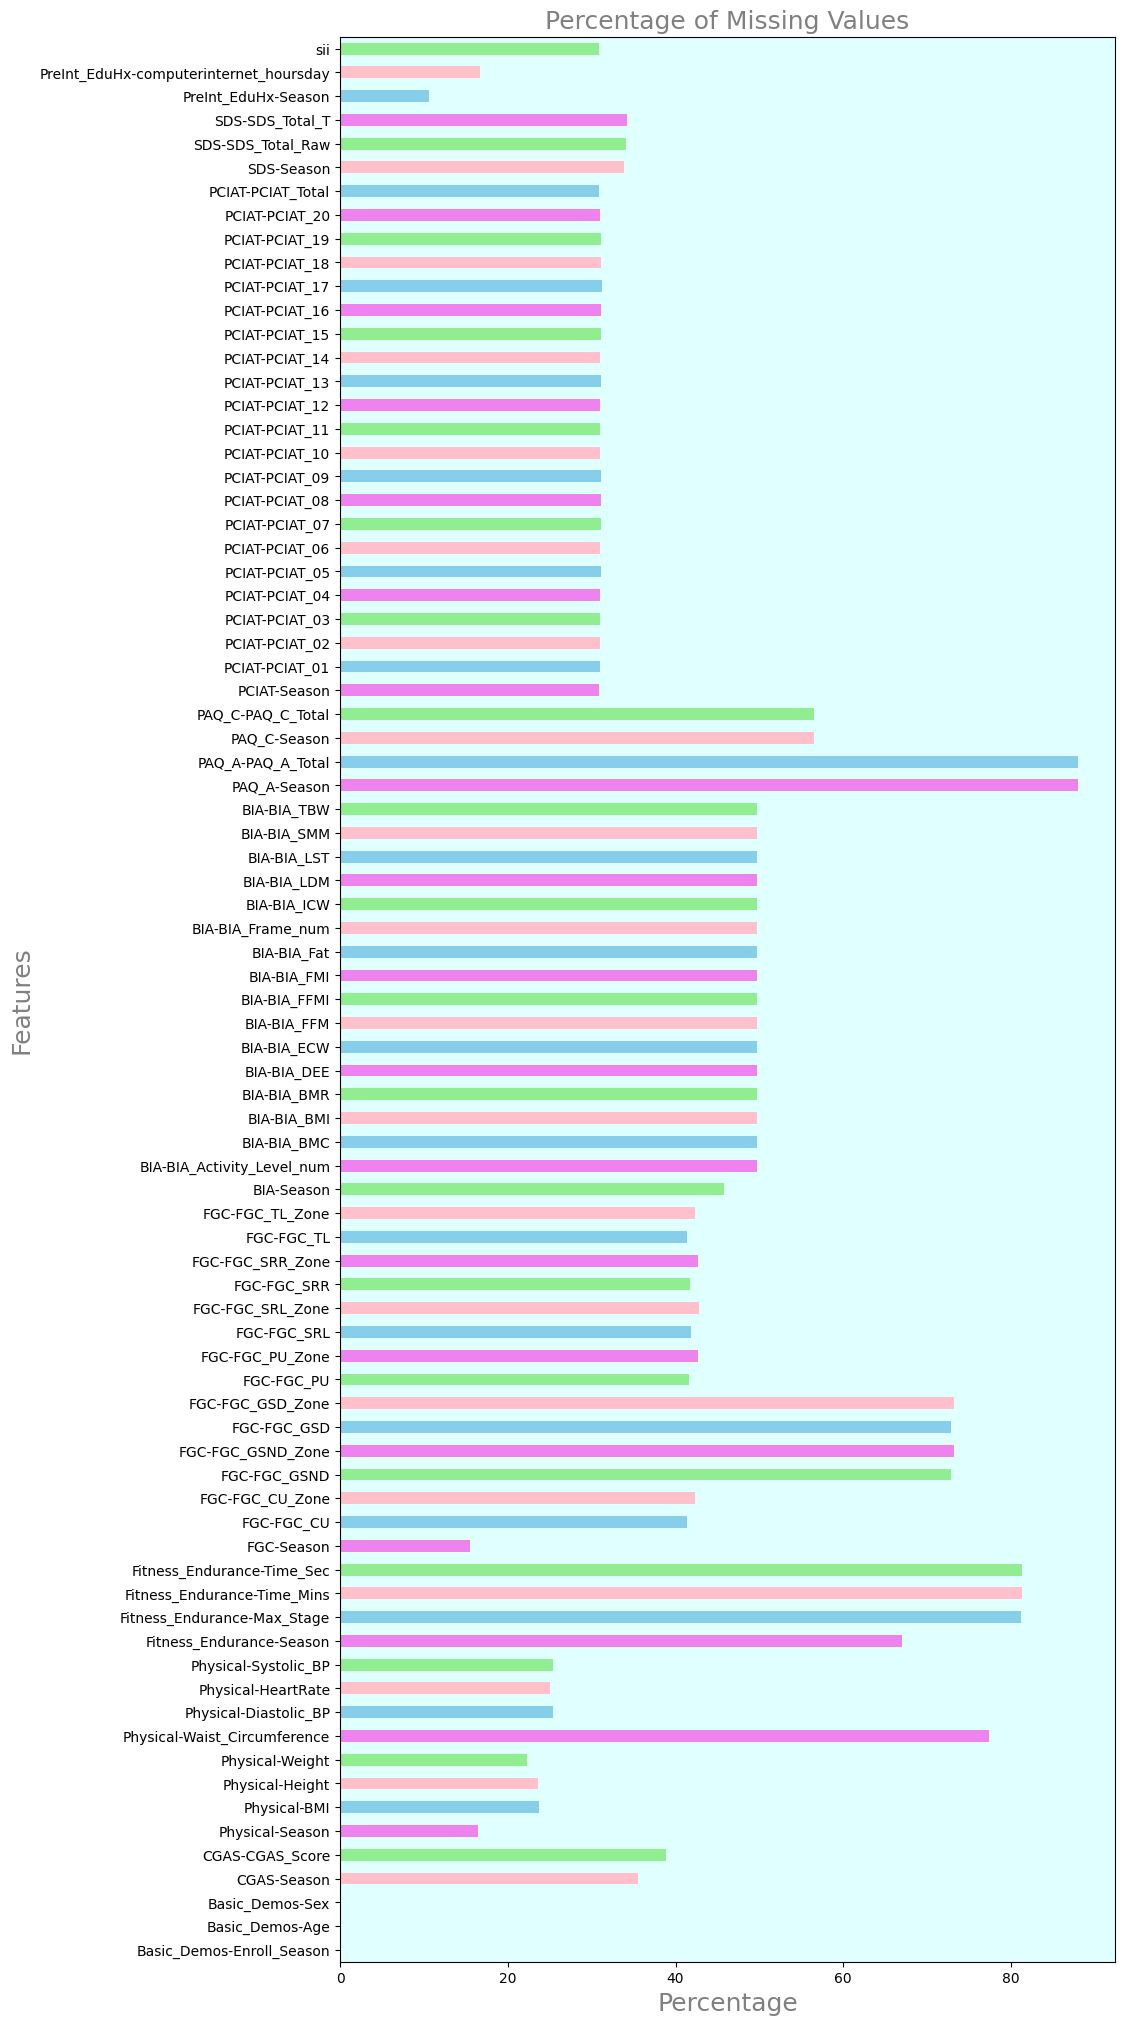

In [ ]:
train = dtrain.copy()
test = dtest.copy()

train_col = train.columns.tolist()
test_col = test.columns.tolist()

missing_values = train.isnull().mean() * 100
missing_values.plot(kind='barh', figsize=(10, 25), color=['lightgreen','violet','skyblue','pink'])

plt.title('Percentage of Missing Values', fontsize=18, color='gray')
plt.xlabel('Percentage', fontsize=18, color='gray')
plt.ylabel('Features', fontsize=18, color='gray')
plt.gca().set_facecolor('lightcyan')
plt.xticks(rotation=0)
plt.show();

In [ ]:
features = test_col.copy()
print('Number of Features :', len(features))

# Numerical Features
num_features = [f for f in features if train[f].dtype==float or f=='Basic_Demos-Age']
print('The number of numerical features :', len(num_features))

# Categorical Features
cat_features = [f for f in features if f not in num_features]
print('The number of categorical features :', len(cat_features))

# Target Features
target_col = [f for f in train_col if f not in test_col]
print('The number of target features :', len(target_col), '\n')


Number of Features : 58
The number of numerical features : 47
The number of categorical features : 11
The number of target features : 23 



In [ ]:
from sklearn.impute import KNNImputer
imputer_num = KNNImputer(n_neighbors=2, weights="uniform")

# .........................................................................
df_data = pd.concat([train[features], test], axis=0)

imputer_num.fit(df_data[num_features])
df_data[num_features] = imputer_num.transform(df_data[num_features])

for col in cat_features:
    df_data[col] = df_data[col].fillna('unknown')
    df_data[col] = df_data[col].astype('category')
df_data.shape, df_data.isnull().mean() * 100

((3980, 58),
 Basic_Demos-Enroll_Season                 0.0
 Basic_Demos-Age                           0.0
 Basic_Demos-Sex                           0.0
 CGAS-Season                               0.0
 CGAS-CGAS_Score                           0.0
 Physical-Season                           0.0
 Physical-BMI                              0.0
 Physical-Height                           0.0
 Physical-Weight                           0.0
 Physical-Waist_Circumference              0.0
 Physical-Diastolic_BP                     0.0
 Physical-HeartRate                        0.0
 Physical-Systolic_BP                      0.0
 Fitness_Endurance-Season                  0.0
 Fitness_Endurance-Max_Stage               0.0
 Fitness_Endurance-Time_Mins               0.0
 Fitness_Endurance-Time_Sec                0.0
 FGC-Season                                0.0
 FGC-FGC_CU                                0.0
 FGC-FGC_CU_Zone                           0.0
 FGC-FGC_GSND                              0.0


In [ ]:
df_code = pd.get_dummies(df_data, columns=cat_features)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_code[num_features] = scaler.fit_transform(df_code[num_features])
df_code.shape

(3980, 98)

In [ ]:
from tqdm import tqdm
from IPython.display import clear_output
from concurrent.futures import ThreadPoolExecutor

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

In [ ]:
def process_file(filename, dirname):
    data = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    data.drop('step', axis=1, inplace=True)
    return data.describe().values.reshape(-1), filename.split('=')[1]
def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)

    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    stats, indexes = zip(*results)

    data = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    data['id'] = indexes
    return data
train_ts = load_time_series('C:\Users\G JASHWANTH KUMAR\Documents\Dataset')
test_ts = load_time_series('C:\Users\G JASHWANTH KUMAR\Documents\Dataset')

time_series_cols = train_ts.columns.tolist()
time_series_cols.remove('id')
train_ts.shape, test_ts.shape, len(time_series_cols)

In [ ]:
df_data_ts = pd.concat([train_ts, test_ts], axis=0)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_data_ts[time_series_cols] = scaler.fit_transform(df_data_ts[time_series_cols])
df_data_ts.shape

In [ ]:
df_code = df_code.reset_index()

train_df = df_code[:3960].copy()
test_df = df_code[3960:].copy()

train_df.shape, test_df.shape, df_code.shape

In [ ]:
train_ts = df_data_ts[:996].copy()
test_ts = df_data_ts[996:].copy()

train_ts.shape, test_ts.shape, df_data_ts.shape

In [ ]:
train_df = pd.merge(train_df, train_ts, how="left", on='id')
test_df = pd.merge(test_df, test_ts, how="left", on='id')
for col in time_series_cols:

    train_df[col] = train_df[col].fillna(train_df[col].median())
    test_df[col] = test_df[col].fillna(test_df[col].median())
train_df.shape, test_df.shape

In [ ]:
df_corr = train_df.copy()
df_corr['sii'] = train['sii'].values.copy()
corr_sii = df_corr.corr(numeric_only=True)['sii']
corr_sii = corr_sii[(corr_sii > 0.02) | (corr_sii < -0.02)]
corr_list = corr_sii.keys().tolist()
corr_list.remove('sii')

len(corr_list)

In [ ]:
y  = train['sii'].copy()
X  = train_df[corr_list].copy()
XX = test_df[corr_list].copy()

y.shape, X.shape, XX.shape

In [ ]:
import lightgbm as lgb
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from bayes_opt import BayesianOptimization
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.metrics import log_loss
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
base_model = lgb.LGBMRegressor(random_state=420, verbose=-1)
print('\nr2_score :', cross_val_score(base_model, X ,y ,cv=5, scoring='r2'))

In [ ]:
def round_t(pred_raw, t):
    pred = np.where(pred_raw < t[0], 0, np.where(pred_raw < t[1], 1, np.where(pred_raw < t[2], 2, 3)))
    return pred
def qw_kappa(y_true, pred):
    return -cohen_kappa_score(y_true, pred, weights='quadratic')
def fun(t, y_true, pred_raw):
    pred = round_t(pred_raw, t)
    return -cohen_kappa_score(y_true, pred, weights='quadratic')
def optimized_thresholds(fun, y_true, pred_raw):
    res = minimize(fun, x0=[0.5, 1.5, 2.5], args=(y_true, pred_raw), method='Nelder-Mead')
    assert res.success
    return res.x.round(2) # optimized_thresholds

t = [0.6, 1.07, 2.52]

In [ ]:
lgbm_params1 = {

    'metric'              :'rmse',
    'objective'           :'regression',
    'learning_rate'       : 0.04,
    'max_depth'           : 12,
    'num_leaves'          : 59,
    'subsample'           : 0.70,
    'colsample_bytree'    : 0.50,
    'min_child_weight'    : 12,
    'min_child_samples'   : 14,
    'reg_alpha'           : 0.23,
    'reg_lambda'          : 0.36,
}
lgbm_params2 = {

    'metric'              :'rmse',
    'objective'           :'regression',
    'learning_rate'       : 0.05,
    'max_depth'           : 9,
    'num_leaves'          : 59,
    'subsample'           : 0.80,
    'colsample_bytree'    : 0.50,
    'min_child_weight'    : 12,
    'min_child_samples'   : 14,
    'reg_alpha'           : 0.23,
    'reg_lambda'          : 0.36,
}
lgbm_params3 = {

    'metric'              :'rmse',
    'objective'           :'regression',
    'learning_rate'       : 0.046,
    'max_depth'           : 12,
    'num_leaves'          : 478,
    'min_data_in_leaf'    : 13,
    'feature_fraction'    : 0.893,
    'bagging_fraction'    : 0.784,
    'bagging_freq'        : 4,
    'lambda_l1'           : 10,
    'lambda_l2'           : 0.01,
}
model1 = lgb.LGBMRegressor(**lgbm_params1, n_estimators=10000, random_state=421, early_stopping_rounds=350, verbose=-1)

model2 = lgb.LGBMRegressor(**lgbm_params2, n_estimators=10000, random_state=422, early_stopping_rounds=350, verbose=-1)

model3 = lgb.LGBMRegressor(**lgbm_params3, n_estimators=10000, random_state=423, early_stopping_rounds=350, verbose=-1)
model_list = [model1, model2, model3]

In [ ]:
from lightgbm import plot_importance
model_b = lgb.LGBMRegressor(**lgbm_params1, verbose=-1)
model_b.fit(X, y)

In [ ]:
plot_importance(model_b, figsize=(12, 30), color=['lightgreen','violet','skyblue','pink'], height=0.6, max_num_features=100,
                title='LightGBM - Feature importance', xlabel='Value', ylabel='Name Feature');

plt.gca().set_facecolor('lightcyan')

In [ ]:
name_list = X.columns.tolist()
weight_list = model_b.feature_importances_

name_weight = []
for i in range(len(name_list)):
    name_weight.append([name_list[i], weight_list[i]])

name_weight_sort = sorted(name_weight, key=lambda x: x[1])

print('Total number of features :', len(name_weight_sort))
weight_list, name_weight_sort[:10]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)
model_t = lgb.LGBMRegressor(**lgbm_params1, verbose=-1)

model_t.fit(X_train, y_train)
predict_t = model_t.predict(X_test)

score_t = cohen_kappa_score(y_test, round_t(predict_t, t), weights='quadratic')
print('Score based on all (', len(name_list), ') features :', score_t, '\n')
X_t = X.copy()
XX_t = XX.copy()

for i in range(len(name_weight_sort)):

    name_i = name_weight_sort[i][0]
    weight_i = name_weight_sort[i][1]

    X_i = X_t.drop(columns=name_i, inplace=False)
    X_train, X_test, y_train, y_test = train_test_split(X_i, y, test_size=0.20, random_state=123)

    model_t.fit(X_train, y_train)
    predict_i = model_t.predict(X_test)

    score_i = cohen_kappa_score(y_test, round_t(predict_i, t), weights='quadratic')
    if (score_t < score_i):
        X_t.drop(columns=name_i, inplace=True)
        XX_t.drop(columns=name_i, inplace=True)
        score_t = score_i

        print('New Score :',round(score_i, 5), '| Weight :', weight_i, '| Name-deleted :', name_i)

print('\nX_t Shape :', X_t.shape, 'XX_t Shape :', XX_t.shape)

In [ ]:
score_mean = 0
th = np.zeros(3)
pred = np.zeros(len(XX))
rkf = RepeatedKFold(n_splits=3, n_repeats=8, random_state=424)

for fold, (train_idx, valid_idx) in enumerate(rkf.split(X)):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_valid, y_valid = X.iloc[valid_idx], y.iloc[valid_idx]

    print(f'\n:::::::::::::::::: Fold ~ {fold+1} :::::::::::::::::::')
    N = random.randrange(4)
         if (N==0):
        print('LGBMRegressor - 1')
        model1.fit(X_train, y_train,
                  eval_set=[(X_valid, y_valid)])
        oof = model1.predict(X_valid)
        prd = model1.predict(XX)

        th_opt = optimized_thresholds(fun, y_valid, oof)
        print('th_opt =', th_opt)
      if (N==1):
        print('LGBMRegressor - 2')
        model2.fit(X_train, y_train,
                  eval_set=[(X_valid, y_valid)])
        oof = model2.predict(X_valid)
        prd = model2.predict(XX)

        th_opt = optimized_thresholds(fun, y_valid, oof)
        print('th_opt =', th_opt)

    if (N==2 or N==3):
        print('LGBMRegressor - 3')
        model3.fit(X_train, y_train,
                  eval_set=[(X_valid, y_valid)])
        oof = model3.predict(X_valid)
        prd = model3.predict(XX)

        th_opt = optimized_thresholds(fun, y_valid, oof)
        print('th_opt =', th_opt)

        score = cohen_kappa_score(y_valid, round_t(oof, th_opt), weights='quadratic')
    print('SCORE:', round(score, 4))

    th += np.array(th_opt)
    score_mean += score
    pred += prd

score_mean = score_mean / rkf.get_n_splits(X, y)
t = np.round(th / rkf.get_n_splits(X, y), 2)
preds_lgbm_raw = pred / rkf.get_n_splits(X, y)
preds_lgbm = round_t(preds_lgbm_raw, t)

print('\n', '='* 40)
print(' .'* 20)
print(' SCORE(mean):', score_mean, '\n')
print(' Optimized thresholds:', t)
print(' .'* 20)
print('='* 40, '\n')

In [ ]:
sns.set()
plt.figure(figsize=(6, 3))
plt.hist(preds_lgbm_raw, bins=50)

plt.gca().set_facecolor('lightcyan')
plt.suptitle('Prediction-raw Histogram', y=0.96, fontsize=16, c='navy')

round(min(preds_lgbm_raw), 3), round(max(preds_lgbm_raw), 3)

In [ ]:
sns.set()
plt.figure(figsize=(6, 3))
plt.hist(preds_lgbm, bins=25)

plt.gca().set_facecolor('lightgreen')
plt.suptitle('Prediction Histogram', y=0.96, fontsize=16, c='navy')

min(preds_lgbm), max(preds_lgbm)

In [ ]:
sub_lgbm = sub_sample.copy()
sub_lgbm['sii'] = preds_lgbm

# ............................................
# sub_lgbm.to_csv('submission.csv', index=False)
print(sub_lgbm['sii'].value_counts())
# Public Score :
!ls

In [ ]:
# ...........................................................................................
Params = {
    'learning_rate': 0.046,
    'max_depth': 12,
    'num_leaves': 478,
    'min_data_in_leaf': 13,
    'feature_fraction': 0.893,
    'bagging_fraction': 0.784,
    'bagging_freq': 4,
    'lambda_l1': 10,
    'lambda_l2': 0.01
}

model_lg = lgb.LGBMRegressor(**Params, random_state=420, verbose=-1, n_estimators=300)
model_lg.fit(X, y)

preds_lg_raw = model_lg.predict(XX)
preds_lg = round_t(preds_lg_raw, t)
sub_lg = sub_sample.copy()
sub_lg['sii'] = preds_lg

# sub_lg.to_csv('submission.csv', index=False)
print(sub_lg['sii'].value_counts())
# Public Score :
!ls

In [ ]:
XGB_Params = {
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,
    'reg_lambda': 5,
    'random_state': 420,
    'tree_method': 'exact'
}
model_xgb = XGBRegressor(**XGB_Params)
model_xgb.fit(X, y)

preds_xgb_raw = model_xgb.predict(XX)
preds_xgb = round_t(preds_xgb_raw, t)
sub_xgb = sub_sample.copy()
sub_xgb['sii'] = preds_xgb

# sub_xgb.to_csv('submission.csv', index=False)
print(sub_xgb['sii'].value_counts())
# Public Score :
!ls


In [ ]:
X_c  = df_data[:3960].copy()
XX_c = df_data[3960:].copy()

# ...........................................................................................
features = X_c.columns.tolist()
print('Number of Features :', len(features))

# Numerical Features
num_features = [f for f in features if X_c[f].dtype==float or f=='Basic_Demos-Age']
print('The number of numerical features :', len(num_features))

# Categorical Features
cat_features = [f for f in features if f not in num_features]
print('The number of categorical features :', len(cat_features))


In [ ]:
CatBoost_Params = {
    'learning_rate': 0.05,
    'depth': 6,
    'iterations': 200,
    'random_seed': 420,
    'cat_features': cat_features,
    'verbose': 0,
    'l2_leaf_reg': 10
}
model_cat = CatBoostRegressor(**CatBoost_Params)
model_cat.fit(X_c, y)

preds_cat_raw = model_cat.predict(XX_c)
preds_cat = round_t(preds_cat_raw, t)
sub_cat = sub_sample.copy()
sub_cat['sii'] = preds_cat

# sub_cat.to_csv('submission.csv', index=False)
print(sub_cat['sii'].value_counts())
# Public Score :
!ls

In [ ]:
from sklearn.svm import LinearSVR

# .............................................................
model_svr = LinearSVR(max_iter= 1000, epsilon= 0.1)
model_svr.fit(X, y)

preds_svr_raw = model_svr.predict(XX)
preds_svr = round_t(preds_svr_raw, t)

# ...........................................................................................
sub_svr = sub_sample.copy()
sub_svr['sii'] = preds_svr

# sub_svr.to_csv('submission.csv', index=False)
print(sub_svr['sii'].value_counts())
# Public Score :
!ls

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)

# ...............................................................................................
def best_knn(coeff):
    neigh_t = KNeighborsRegressor(n_neighbors=coeff)
    neigh_t.fit(X_train, y_train)

    predict_t = neigh_t.predict(X_test)
    score = cohen_kappa_score(y_test, round_t(predict_t, t), weights='quadratic')
    return score
results = {}
for i in range(3, 21, 2):
    results[i] = best_knn(i)

sns.set()
plt.figure(figsize=(8, 5))
plt.gca().set_facecolor('lightcyan')
plt.suptitle('Results based on changes in "n_neighbors"', y=0.92, fontsize=14, c='gray')

plt.plot(list(results.keys()), list(results.values()))
plt.show()

In [ ]:
neigh = KNeighborsRegressor(n_neighbors=7)
neigh.fit(X, y)

preds_knn_raw = neigh.predict(XX)
preds_knn = round_t(preds_knn_raw, t)

# ...................................................
sub_knn = sub_sample.copy()
sub_knn['sii'] = preds_knn

# sub_knn.to_csv('submission.csv', index=False)
print(sub_knn['sii'].value_counts())
# Public Score :
!ls

In [ ]:
preds_ens_raw = (preds_lgbm_raw + preds_lgbm_raw + preds_lg_raw + preds_xgb_raw + preds_cat_raw ) / 5
preds_ens = round_t(preds_ens_raw, t)

# ..........................................................................................................
sub_ens = sub_sample.copy()
sub_ens['sii'] = preds_ens

sub_ens.to_csv('submission.csv', index=False)
print(sub_ens['sii'].value_counts())
# Public Score:
!ls